In [25]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate with Kaggle
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = 'blastchar/telco-customer-churn'
api.dataset_download_files(dataset, path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn


In [26]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("TelcoChurnPreprocessing").getOrCreate()

# Load the data file
file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
telco_base_data = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the data
telco_base_data.show(5)


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [27]:
# Display the schema and the first few rows
telco_base_data.printSchema()
telco_base_data.show(5)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

In [28]:
# Display the shape of the data
print(f"Data shape: ({telco_base_data.count()}, {len(telco_base_data.columns)})")

# Display the columns and their data types
telco_base_data.dtypes

# Describe the numeric columns
telco_base_data.describe().show()

# Check for missing values
telco_base_data.select([((telco_base_data[c] == '') | telco_base_data[c].isNull()).alias(c) for c in telco_base_data.columns]).groupBy().sum().show()

Data shape: (7043, 21)
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043| 

In [29]:
telco_data = telco_base_data

In [30]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [31]:
# Convert TotalCharges to float and handle missing values
telco_data = telco_data.withColumn("TotalCharges", F.col("TotalCharges").cast(FloatType()))
telco_data = telco_data.dropna(subset=["TotalCharges"])

# Create tenure groups
telco_data = telco_data.withColumn("tenure_group", 
                                    F.when(F.col("tenure").between(1, 12), "1-12")
                                    .when(F.col("tenure").between(13, 24), "13-24")
                                    .when(F.col("tenure").between(25, 36), "25-36")
                                    .when(F.col("tenure").between(37, 48), "37-48")
                                    .when(F.col("tenure").between(49, 60), "49-60")
                                    .otherwise("61-72"))

# Drop unnecessary columns
telco_data = telco_data.drop("customerID", "tenure")

# Convert target variable 'Churn' to binary numeric variable
telco_data = telco_data.withColumn("Churn", F.when(F.col("Churn") == "Yes", 1).otherwise(0))

# Convert categorical variables to dummy variables
categorical_cols = [col for col, dtype in telco_data.dtypes if dtype == 'string']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_cols]
pipeline = Pipeline(stages=indexers)
telco_data = pipeline.fit(telco_data).transform(telco_data)

# Drop original categorical columns
telco_data = telco_data.drop(*categorical_cols)

In [36]:
telco_data.show(2)

+-------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+------------------+
|SeniorCitizen|MonthlyCharges|TotalCharges|Churn|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|InternetService_index|OnlineSecurity_index|OnlineBackup_index|DeviceProtection_index|TechSupport_index|StreamingTV_index|StreamingMovies_index|Contract_index|PaperlessBilling_index|PaymentMethod_index|tenure_group_index|
+-------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

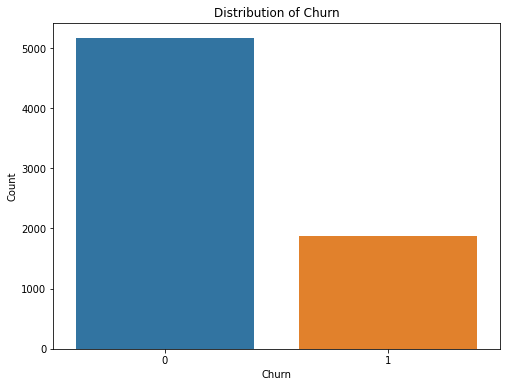

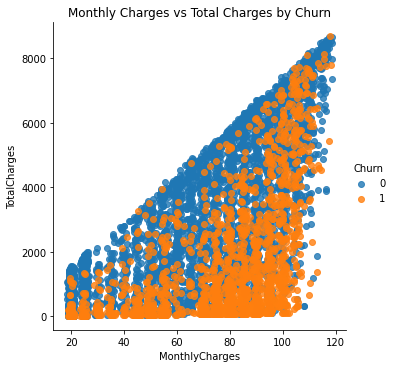

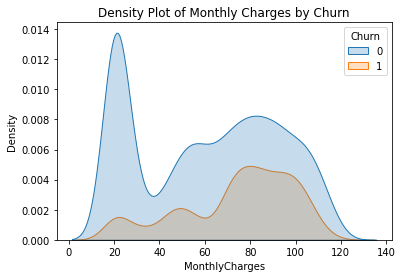

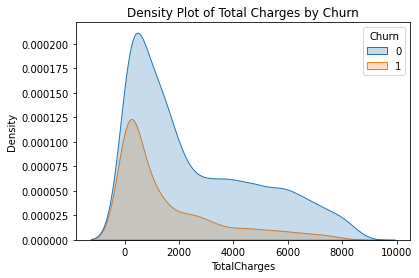

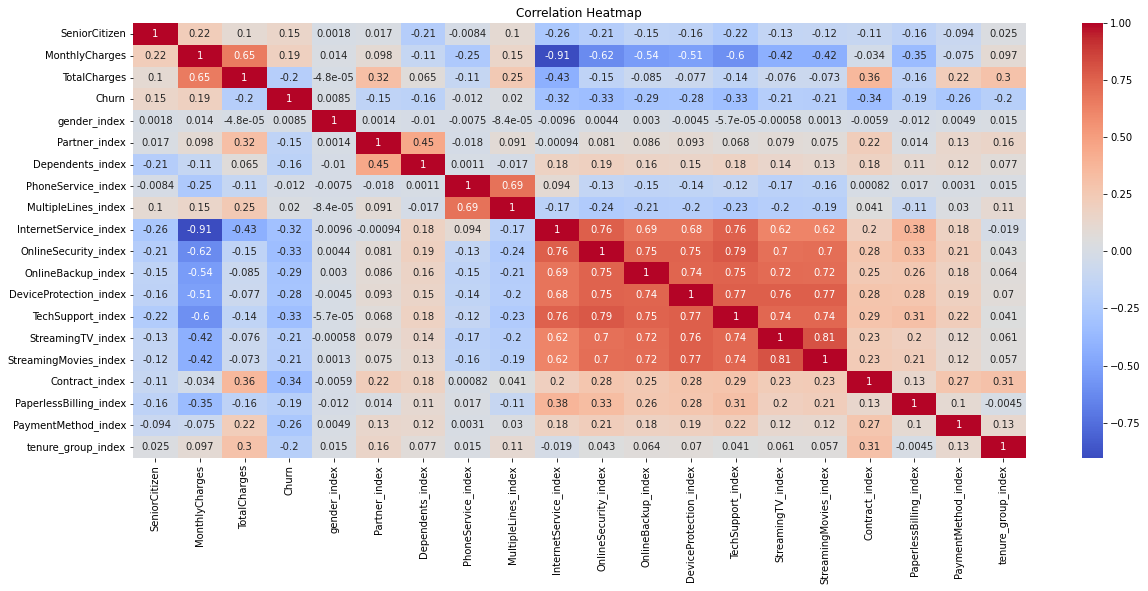

In [34]:
# Assuming telco_data_prepared is your final Spark DataFrame after data cleaning and preparation
# Convert to Pandas DataFrame for visualization
telco_data_pd = telco_data.toPandas()

# Univariate Analysis: Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=telco_data_pd)
plt.xlabel("Churn")
plt.ylabel("Count")
plt.title("Distribution of Churn")
plt.show()

# Bivariate Analysis: Monthly Charges vs Total Charges by Churn
sns.lmplot(data=telco_data_pd, x='MonthlyCharges', y='TotalCharges', hue='Churn', fit_reg=False)
plt.title('Monthly Charges vs Total Charges by Churn')
plt.show()

# Plot density of Monthly Charges by Churn
sns.kdeplot(data=telco_data_pd, x='MonthlyCharges', hue='Churn', shade=True)
plt.title('Density Plot of Monthly Charges by Churn')
plt.show()

# Plot density of Total Charges by Churn
sns.kdeplot(data=telco_data_pd, x='TotalCharges', hue='Churn', shade=True)
plt.title('Density Plot of Total Charges by Churn')
plt.show()

# Correlation heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(telco_data_pd.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [38]:
# Assemble feature vector
feature_cols = telco_data.columns
feature_cols.remove("Churn")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
telco_vector_data = assembler.transform(telco_data)

# Select only the features and target variable for the model
final_data = telco_vector_data.select("features", "Churn")

final_data.show(2)

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|(19,[1,2,3,4,6,7,...|    0|
|(19,[1,2,8,9,11,1...|    0|
+--------------------+-----+
only showing top 2 rows



In [39]:
final_data.show(10)

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|(19,[1,2,3,4,6,7,...|    0|
|(19,[1,2,8,9,11,1...|    0|
|(19,[1,2,8,9,10,1...|    1|
|[0.0,42.3,1840.75...|    0|
|(19,[1,2,3],[70.7...|    1|
|(19,[1,2,3,7,11,1...|    1|
|(19,[1,2,5,7,10,1...|    0|
|(19,[1,2,3,6,7,8,...|    0|
|(19,[1,2,3,4,7,11...|    1|
|(19,[1,2,5,8,9,10...|    0|
+--------------------+-----+
only showing top 10 rows



In [40]:
y = final_data['features']
y

Column<'features'>

In [42]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# from imblearn.combine import SMOTEENN

In [58]:
# Convert Spark DataFrame to Pandas DataFrame for scikit-learn
final_data_pd = telco_data.toPandas()

# Separate features and target variable
X = telco_data_pd.drop('Churn', axis=1)
y = telco_data_pd['Churn']

In [47]:
final_data_pd

,features,Churn
0,"(0.0, 29.85, 29.850000381469727, 1.0, 1.0, 0.0...",0
1,"(0.0, 56.95, 1889.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"(0.0, 53.85, 108.1500015258789, 0.0, 0.0, 0.0,...",1
3,"[0.0, 42.3, 1840.75, 0.0, 0.0, 0.0, 1.0, 2.0, ...",0
4,"(0.0, 70.7, 151.64999389648438, 1.0, 0.0, 0.0,...",1
...,...,...
7027,"[0.0, 84.8, 1990.5, 0.0, 1.0, 1.0, 0.0, 1.0, 1...",0
7028,"[0.0, 103.2, 7362.89990234375, 1.0, 1.0, 1.0, ...",0
7029,"(0.0, 29.6, 346.45001220703125, 1.0, 1.0, 1.0,...",0
7030,"(1.0, 74.4, 306.6000061035156, 0.0, 1.0, 0.0, ...",1


In [59]:
telco_data_pd

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,tenure_group_index
0,0,29.85,29.850000,0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,56.95,1889.500000,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0
2,0,53.85,108.150002,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,42.30,1840.750000,0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,5.0
4,0,70.70,151.649994,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,84.80,1990.500000,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0
7028,0,103.20,7362.899902,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,3.0,1.0
7029,0,29.60,346.450012,0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,1,74.40,306.600006,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [67]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X.columns

Index(['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'gender_index',
       'Partner_index', 'Dependents_index', 'PhoneService_index',
       'MultipleLines_index', 'InternetService_index', 'OnlineSecurity_index',
       'OnlineBackup_index', 'DeviceProtection_index', 'TechSupport_index',
       'StreamingTV_index', 'StreamingMovies_index', 'Contract_index',
       'PaperlessBilling_index', 'PaymentMethod_index', 'tenure_group_index'],
      dtype='object')

In [74]:
type(X)

pandas.core.frame.DataFrame

In [75]:
import json

In [78]:
json_data = X_test.to_json(orient='records')

In [83]:
num_entries = len(json.loads(json_data))
print(f"Number of entries in json_data : {num_entries}")

Number of entries in json_data : 1407


In [85]:
json_data[:10]

'[{"SeniorC'

In [84]:
# Alternatively, save to a JSON file
with open('json_test_data.json', 'w') as f:
    json.dump(json.loads(json_data), f, indent=4)  # Indent for readability

In [61]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [62]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [68]:
y_pred=model_dt.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [70]:
print(model_dt.score(X_test,y_test))
print(classification_report(y_test, y_pred, labels=[0,1]))

0.7668798862828714
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.59      0.57       374

    accuracy                           0.77      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407



In [71]:
import joblib

In [72]:
# Save the model
joblib.dump(model_dt, 'decision_tree_model.pkl')

['decision_tree_model.pkl']